## Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

In [3]:
import pandas as pd
import math
import os

# Helper Functions

In [4]:
def show_image(image, cmap="gray", text=""):
        plt.imshow(image, cmap=cmap)
        plt.text(0,image.shape[0]*1.25,text)
        plt.show()
        
def binary_threshold_channel(channel, thresh=(90,255)):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def compute_radius_of_curvature(fit, y):
    A,B,C = fit
    return ((1 + (2*A*y + B)**2)**1.5) / np.absolute(2*A)

# Apply distortion correction to raw images.

In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
import glob

In [7]:
def calibrate(path='./camera_cal/calibration*.jpg'):
    image_paths = glob.glob(path)
    imagepoints = []
    objpoints = []

    nx = 9
    ny = 6

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Convert to grayscale
    for image_path in image_paths:
        # print("processing {}".format(image_path))
        image = read_image(image_path)
        img = image.copy()

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        show_image(image, text="Gray Scale Image")

        # Find the chessboard corners
        corner_ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if corner_ret == True:
        # Draw and display the corners
            imagepoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(image, (nx, ny), corners, corner_ret)

            show_image(img, text="Distored Image")

            # * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imagepoints, img.shape[1::-1], None, None)

            undistorted = cv2.undistort(img, mtx, dist, None, mtx)

            show_image(undistorted, text="Undistorted")

            src = np.float32([corners[0],corners[8],corners[35],corners[27]])

            w, h = img.shape[1::-1]

            top = 0.1; bottom = 0.55; left = 0.1; right = 0.9

            dst = np.float32([[w*left, h*top],[w*right, h*top],[w*right, h*bottom],[w*left, h*bottom]])

            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)

            # e) use cv2.warpPerspective() to warp your image to a top-down view
            warped = cv2.warpPerspective(undistorted, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
            show_image(warped, text="Perspective Warped image")

    calibration_values = {
        'imgpoints': imagepoints,
        'objpoints': objpoints,
        'mtx_distortion_correction': mtx,
        'distortion_coefficient': dist
    }
    pickle.dump(calibration_values, open( "calibration_values.p", "wb" ) )

# Single Image Test

In [8]:
from pipeline import Pipeline

In [9]:
image_list = os.listdir("./test_frames/")

if '.DS_Store' in image_list:
    image_list.remove('.DS_Store')

In [67]:
i=0

p = Pipeline()

1


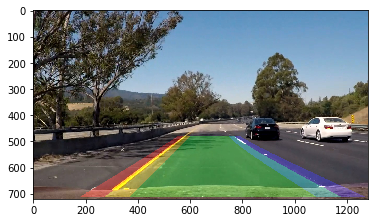

In [82]:
print(i)

image_path = image_list[i]

image = p.find_lanes("./test_frames/"+image_path);

show_image(image)

In [172]:
binary_warped = np.copy(p.image)

self = p

binary_warped = self.image
left_fit = self.left_lane.current_fit
right_fit = self.right_lane.current_fit

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

y_vals = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] ).astype(int)
x_vals = (right_fit[0]*(y_vals**2) + right_fit[1]*y_vals + right_fit[2]).astype(int)
binary_warped = superimpose_previous_lane_fit(binary_warped, y_vals, x_vals)

y_vals = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] ).astype(int)
x_vals = (left_fit[0]*(y_vals**2) + left_fit[1]*y_vals + left_fit[2]).astype(int)
binary_warped = superimpose_previous_lane_fit(binary_warped, y_vals, x_vals)

In [171]:
def superimpose_previous_lane_fit(binary_warped, y_vals, x_vals):
    all_y_vals = [y_vals]*10
    all_x_vals = []

    for i, y_vals in enumerate(all_y_vals):
        x_vals = x_vals + (i * (1 + (i%2*-2)) )
        all_x_vals.append(x_vals)

    all_x_vals = np.concatenate(all_x_vals)
    all_y_vals = np.concatenate(all_y_vals)

    binary_warped[all_y_vals, all_x_vals] = 1
    
    return binary_warped

# All Test Images

In [ ]:
p = Pipeline()
for i in range(0,len(image_list)):
    image_path = image_list[i]
    p.find_lanes("./video_output/"+image_path);

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from pipeline import Pipeline
from functools import partial

def gen():
    for i in range(10,10000):
        yield i
        
g = gen()

def process_image(image, pipeline=None):
    result = pipeline.find_lanes(image, show=False)
    return result

def extract_frames(image):
    result = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite('./test_frames/frame_{}.jpg'.format(next(g)),result)
    return result

pipeline = Pipeline()
detect_lanes = partial(process_image, pipeline=pipeline)

clip1 = VideoFileClip("project_video.mp4")

output_dir = "./output"
file_name = "project_video.mp4"

output_path = os.path.join(output_dir, file_name)
video_output_path = os.path.realpath(output_path)

output_clip = clip1.fl_image(detect_lanes)
# output_clip = clip1.fl_image(detect_lanes).subclip(39,44)

%time output_clip.write_videofile(video_output_path, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(output_path))

[MoviePy] >>>> Building video /Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4
[MoviePy] Writing video /Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4


100%|█████████▉| 1260/1261 [11:31<00:00,  1.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/amoghparam/workspace/amogh/sdc/sdc_project4/output/project_video.mp4 

CPU times: user 15min 49s, sys: 1min 17s, total: 17min 7s
Wall time: 11min 32s
